In [1]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True
#import apex

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback
from apex import amp
import segmentation_models_pytorch as smp

In [2]:
def get_img(x, folder: str='train_img'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [3]:
path = '../data'
os.listdir(path)

['test_img', 'train_img', 'train.csv', 'sample_submission.csv']

In [4]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [5]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [6]:
n_train = len(os.listdir(f'{path}/train_img'))
n_test = len(os.listdir(f'{path}/test_img'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [7]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Flower    5546
Fish      5546
Gravel    5546
Sugar     5546
Name: Image_Label, dtype: int64

In [8]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

In [9]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

In [10]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [11]:
train.head(5)

,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


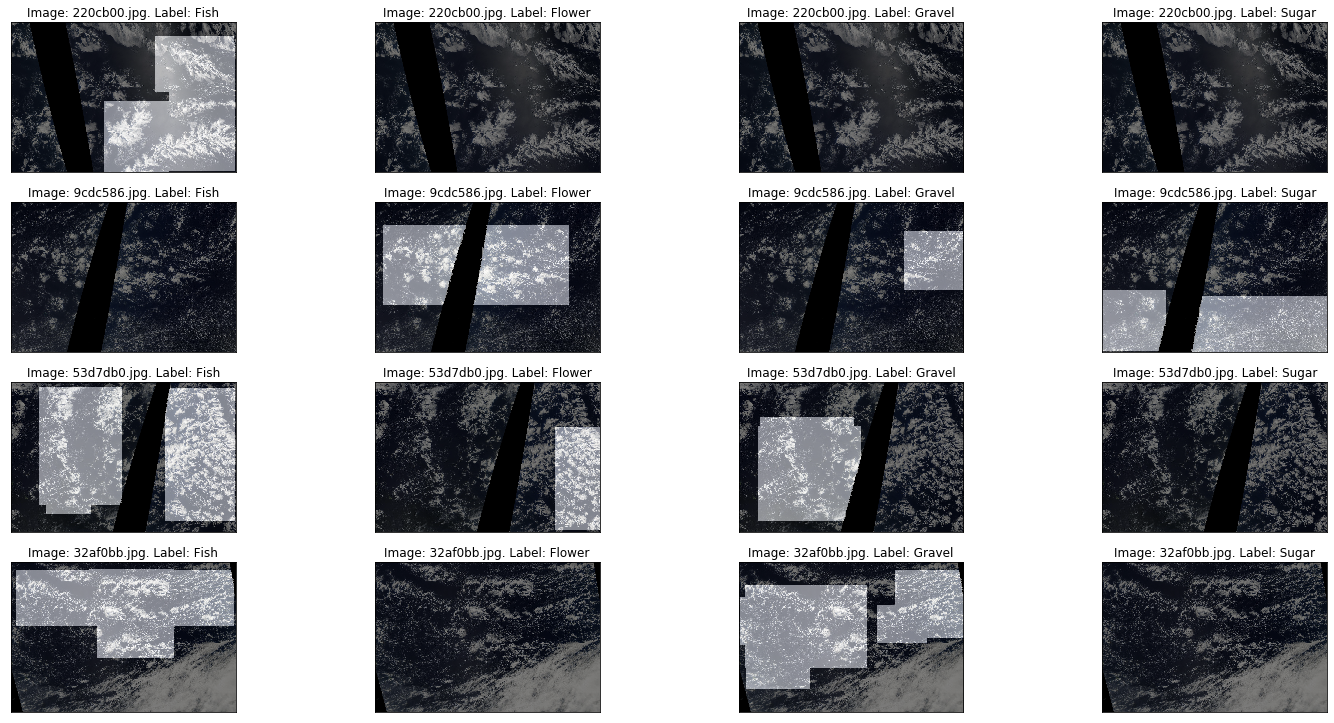

In [12]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{path}/train_img/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

In [13]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [14]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

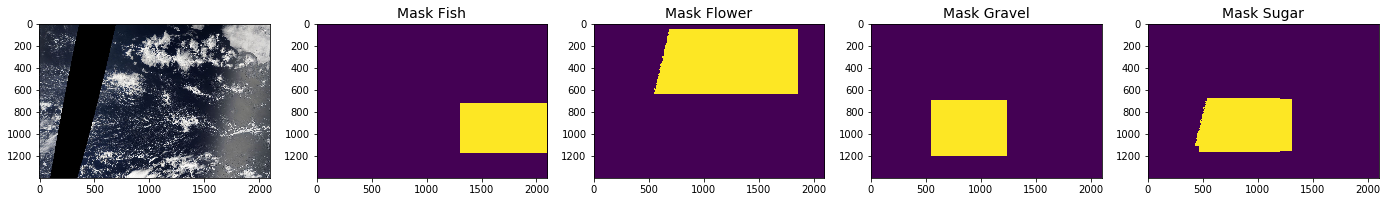

In [15]:
visualize(image, mask)

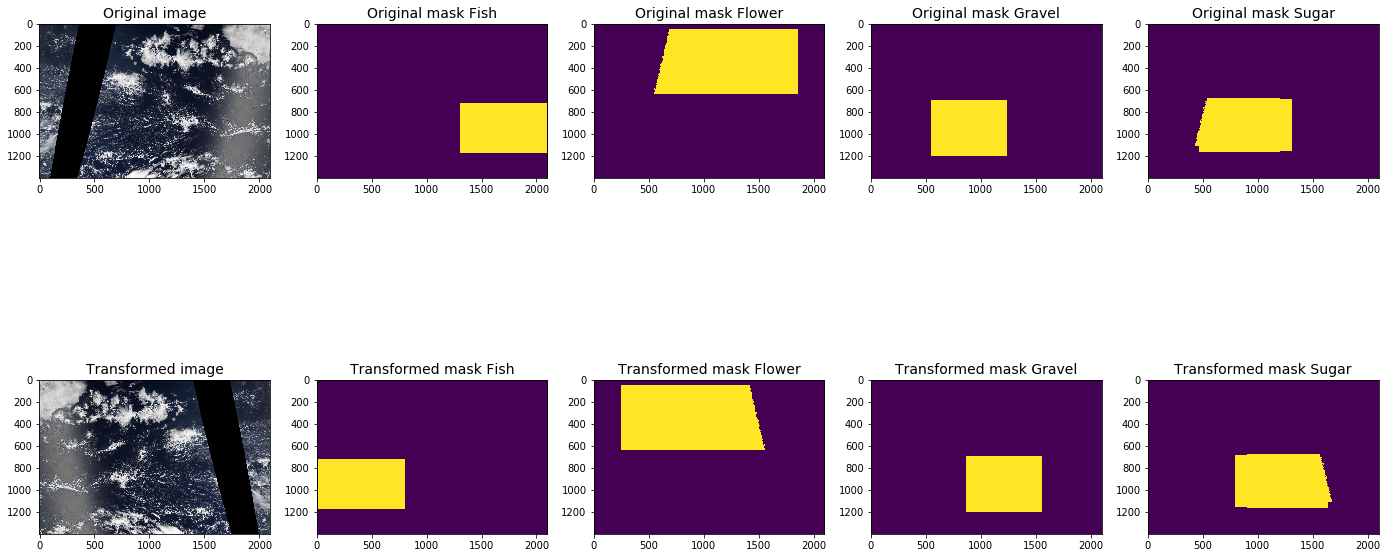

In [16]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

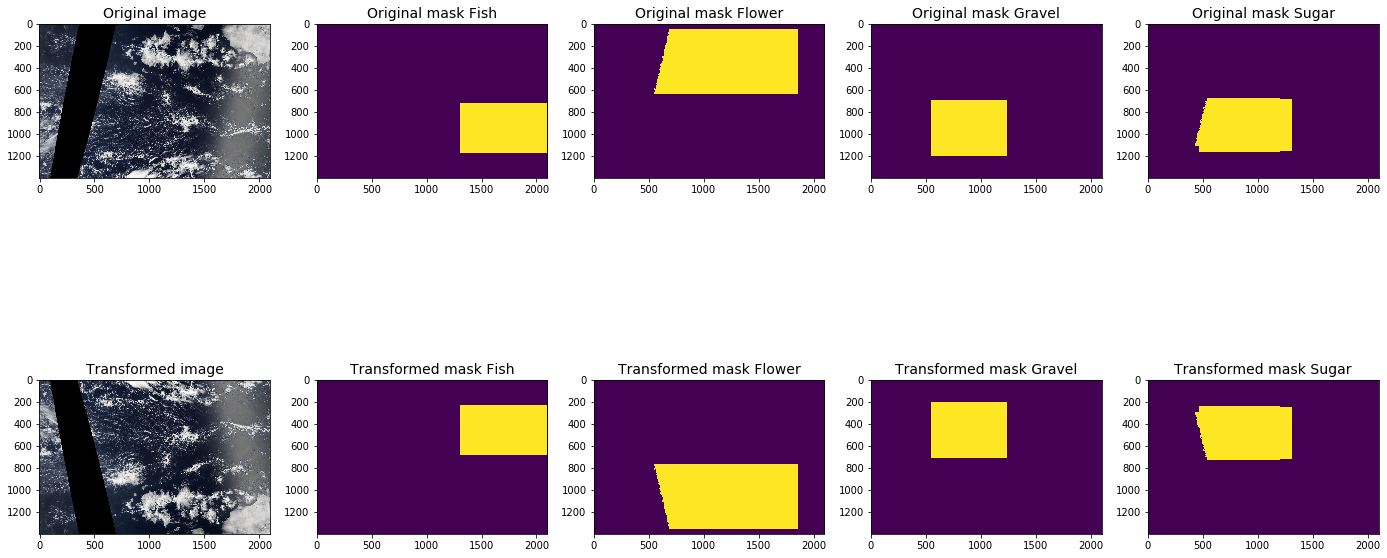

In [17]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

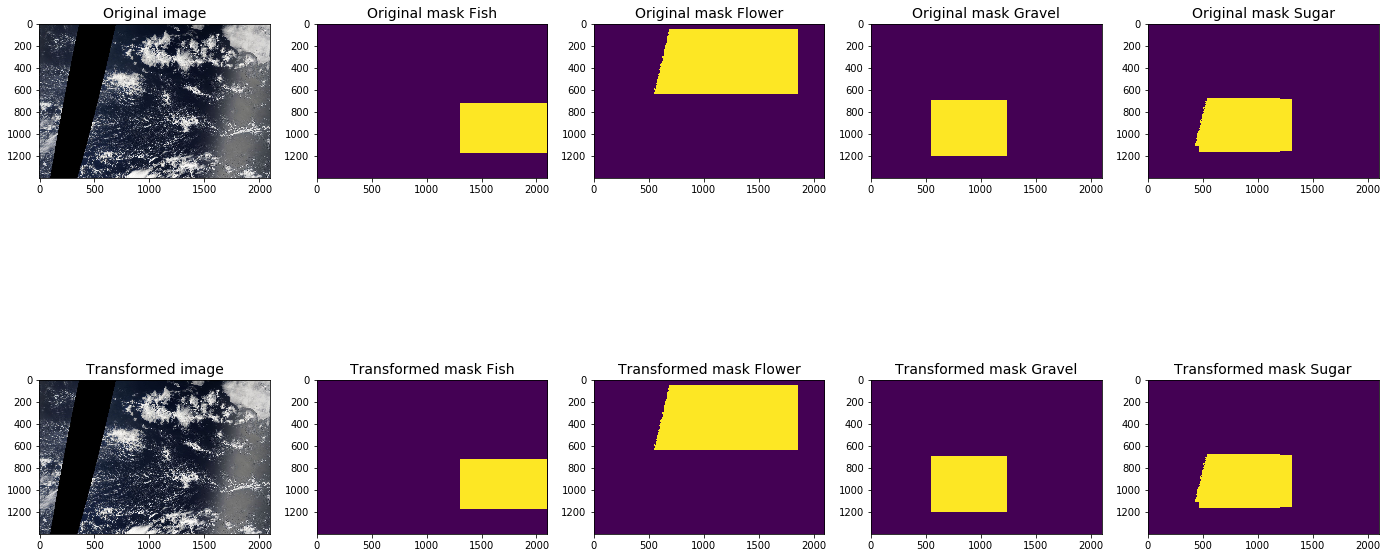

In [18]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

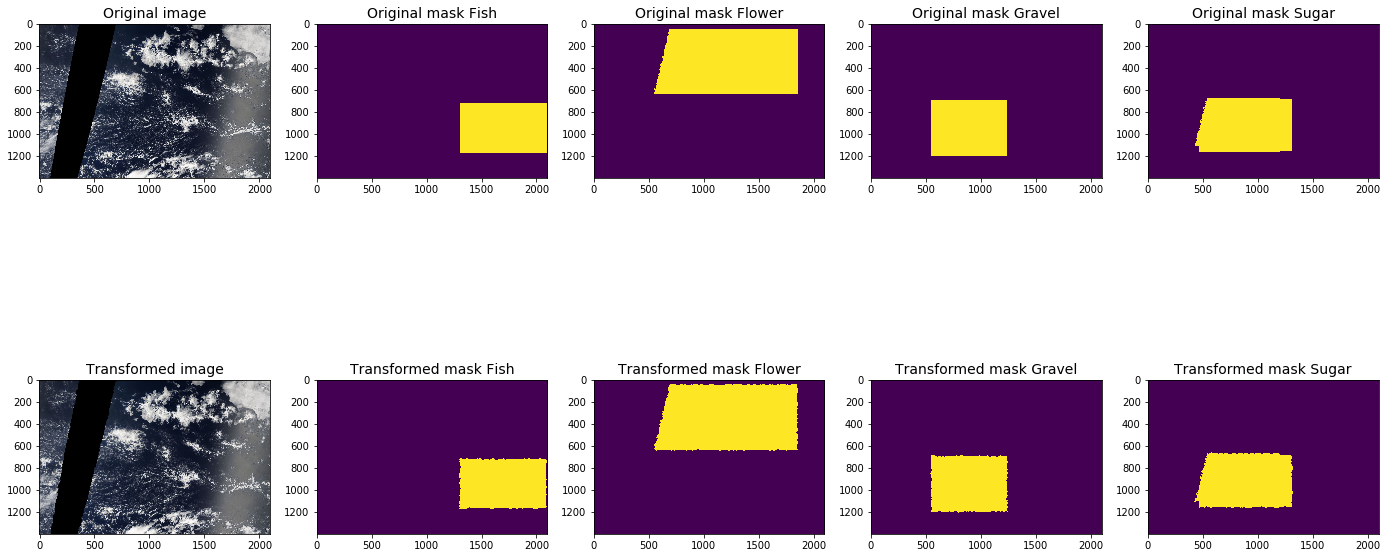

In [19]:
plot_with_augmentation(image, mask, albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03))

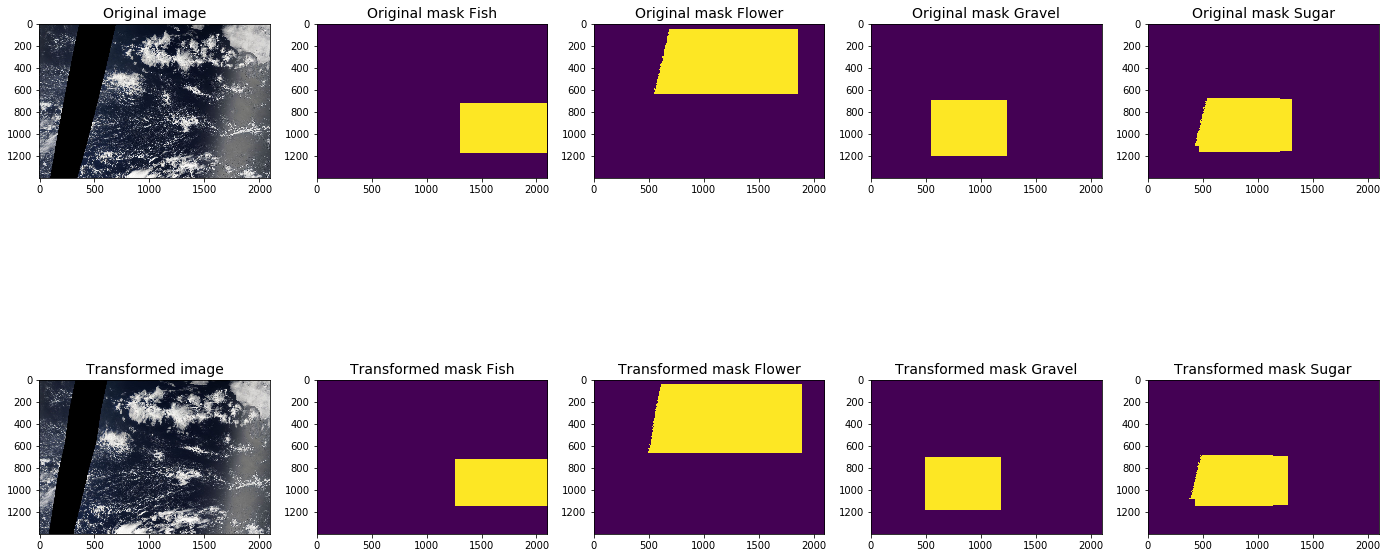

In [20]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

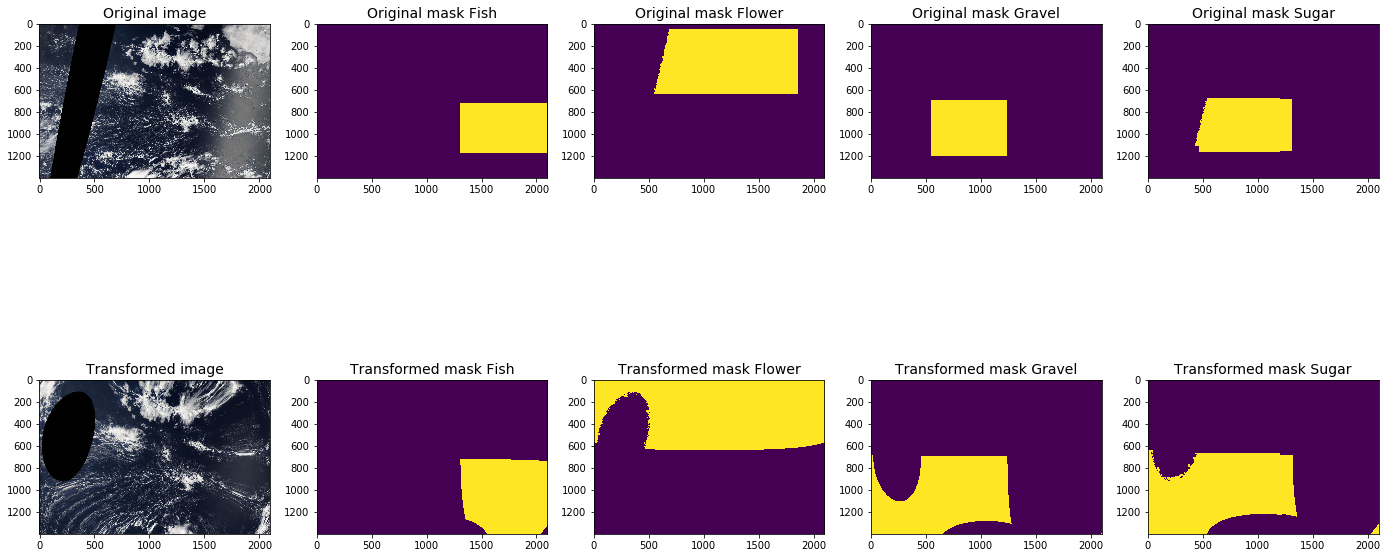

In [21]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))

In [22]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),albu.VerticalFlip()
                                            ,AT.ToTensor()]),
                preprocessing=albu.Equalize):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_img"
        else:
            self.data_folder = f"{path}/test_img"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [23]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [24]:
num_workers = 8
bs = 64
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [25]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [26]:
import apex
num_epochs = 50
logdir = "./logs/segmentation_unet_resnet18"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
opt_level = 'O2'
model.cuda()
model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
# criterion = MixedLoss(10.0, 2.0)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [27]:
# num_epochs = 29
# logdir = "./logs/segmentation"

# # model, criterion, optimizer
# optimizer = torch.optim.Adam([
#     {'params': model.decoder.parameters(), 'lr': 1e-2}, 
#     {'params': model.encoder.parameters(), 'lr': 1e-3},  
# ])
# scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
# criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
# runner = SupervisedRunner()

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0/50 * Epoch (train): 100% 78/78 [04:52<00:00,  3.75s/it, _timers/_fps=474.001, dice=0.441, loss=0.871]
0/50 * Epoch (valid): 100% 9/9 [00:20<00:00,  2.28s/it, _timers/_fps=22.636, dice=0.409, loss=1.168] 
[2019-10-30 11:28:37,360] 
0/50 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=276.8531 | _timers/batch_time=2.5576 | _timers/data_time=2.5377 | _timers/model_time=0.0198 | dice=0.3686 | loss=0.9934
0/50 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=365.2074 | _timers/batch_time=1.9702 | _timers/data_time=1.9620 | _timers/model_time=0.0081 | dice=0.3851 | loss=1.2110
1/50 * Epoch (train): 100% 78/78 [04:47<00:00,  3.69s/it, _timers/_fps=428.305, dice=0.495, loss=0.826]
1/50 * Epoch (valid): 100% 9/9 [00:16<00:00,  1.86s/it, _timers/_fps=69.987, dice=0.468, loss=0.912] 
[2019-10-30 11:33:45,905] 
1/50 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=249.5551 | _timers/batch_time=2.4906 | _timers/data_time=

In [ ]:
# utils.plot_metrics(
#     logdir=logdir, 
#     # specify which metrics we want to plot
#     metrics=["loss", "dice", 'lr', '_base/lr']
# )

In [32]:
import ttach as tta
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip()
        
    ]
)

In [33]:
encoded_pixels = []
loaders = {"infer": valid_loader}

#tta_model = 

runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

#runner.model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

=> loading checkpoint ./logs/segmentation_unet_resnet18/checkpoints/best.pth
loaded checkpoint ./logs/segmentation_unet_resnet18/checkpoints/best.pth (epoch 16)



0it [00:00, ?it/s]
1it [00:00,  8.96it/s]

Top best models:




2it [00:00,  8.78it/s]
3it [00:00,  9.05it/s]
4it [00:00,  8.51it/s]
5it [00:00,  8.85it/s]
6it [00:00,  8.60it/s]
7it [00:00,  8.73it/s]
8it [00:00,  8.93it/s]
9it [00:01,  8.73it/s]
10it [00:01,  8.73it/s]
11it [00:01,  8.67it/s]
12it [00:01,  8.40it/s]
13it [00:01,  8.78it/s]
14it [00:01,  8.77it/s]
15it [00:01,  8.71it/s]
17it [00:01,  9.03it/s]
18it [00:02,  8.64it/s]
19it [00:02,  8.27it/s]
20it [00:02,  8.49it/s]
21it [00:02,  8.54it/s]
22it [00:02,  8.93it/s]
23it [00:02,  8.56it/s]
24it [00:02,  8.43it/s]
25it [00:02,  8.09it/s]
26it [00:03,  8.48it/s]
27it [00:03,  8.61it/s]
28it [00:03,  8.64it/s]
29it [00:03,  8.87it/s]
30it [00:03,  8.65it/s]
31it [00:03,  8.50it/s]
32it [00:03,  8.50it/s]
33it [00:03,  8.41it/s]
34it [00:03,  7.94it/s]
35it [00:04,  7.85it/s]
36it [00:04,  8.05it/s]
37it [00:04,  8.48it/s]
38it [00:04,  8.35it/s]
39it [00:04,  7.89it/s]
40it [00:04,  8.25it/s]
41it [00:04,  8.63it/s]
42it [00:04,  8.40it/s]
43it [00:05,  8.26it/s]
44it [00:05,  8.41it/s]

In [34]:
runner.model = tta.SegmentationTTAWrapper(model, transforms, merge_mode='mean')

In [35]:
runner.model

SegmentationTTAWrapper(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [36]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
59       0.55  10000  0.597267
69       0.65  10000  0.595408
64       0.60  10000  0.592139
79       0.75  10000  0.589610
74       0.70  10000  0.589032
1
    threshold   size      dice
69       0.65  10000  0.742243
64       0.60  10000  0.741220
59       0.55  10000  0.739919
74       0.70  10000  0.738455
54       0.50  10000  0.735766
2
    threshold   size      dice
69       0.65  10000  0.589921
64       0.60  10000  0.589870
44       0.40  10000  0.582249
49       0.45  10000  0.582200
59       0.55  10000  0.581952
3
    threshold   size      dice
64       0.60  10000  0.598473
49       0.45  10000  0.598468
54       0.50  10000  0.597924
44       0.40  10000  0.594750
59       0.55  10000  0.593630


In [40]:
class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
84       0.80  10000  0.546952
79       0.75  10000  0.536471
89       0.85  10000  0.535483
74       0.70  10000  0.535009
69       0.65  10000  0.524628
1
    threshold   size      dice
29       0.25  10000  0.702711
24       0.20  10000  0.698118
34       0.30  10000  0.697146
39       0.35  10000  0.694043
38       0.35   5000  0.693558
2

In [41]:
best_threshold

0.6

In [64]:
class_params = {0: (0.6, 10000), 1: (0.6, 10000), 2: (0.6, 10000), 3: (0.6, 10000)}
print(class_params)

{0: (0.6, 10000), 1: (0.6, 10000), 2: (0.6, 10000), 3: (0.6, 10000)}


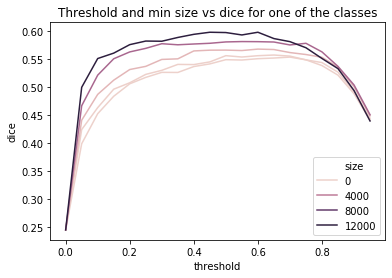

In [65]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice for one of the classes');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


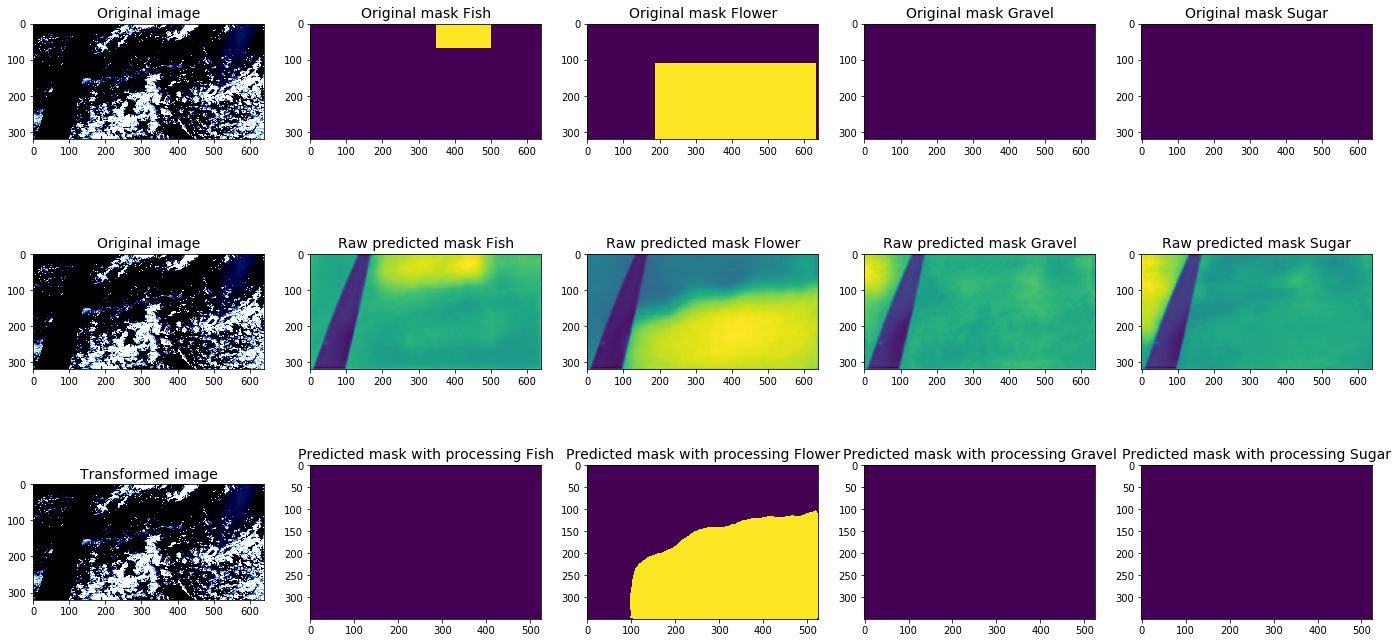

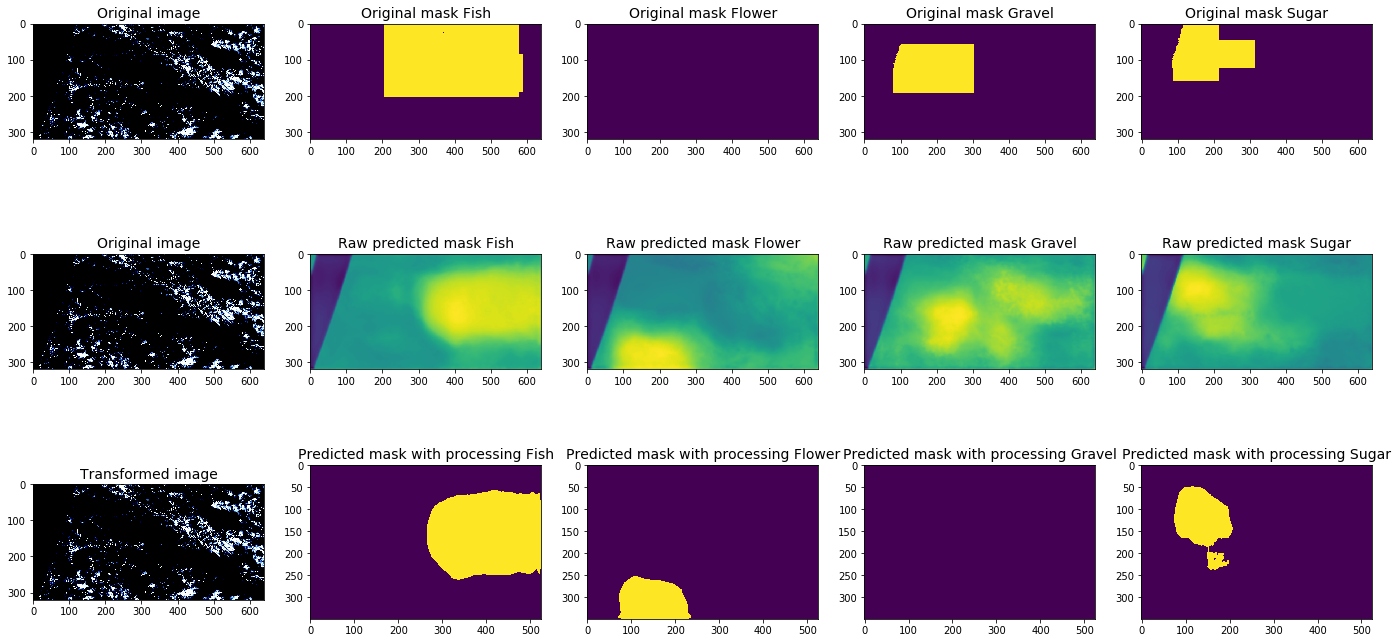

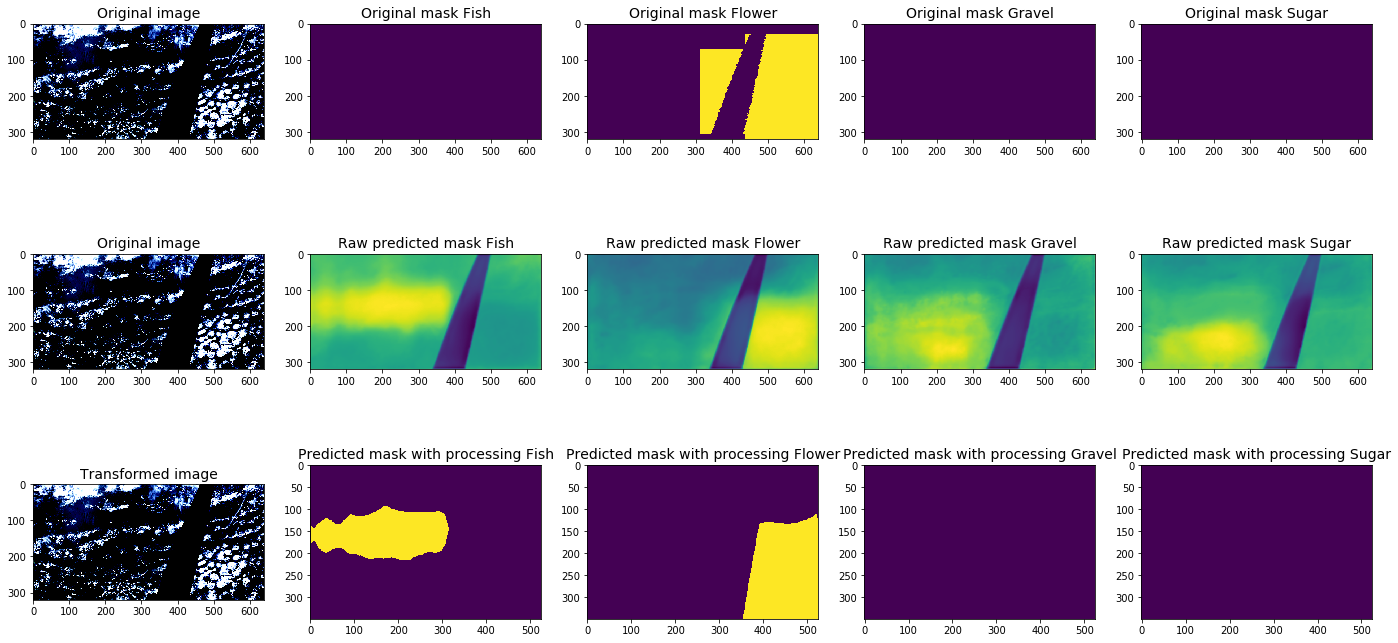

In [66]:
for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"])):
    image, mask = input
        
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = cv2.resize(output.transpose(1, 2, 0)[:, :, j], dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        pr_mask[:, :, j], _ = post_process(sigmoid(probability), class_params[j][0], class_params[j][1])
    #pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)
    
        
    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis, raw_mask=output.transpose(1, 2, 0))
    
    if i >= 2:
        break

In [67]:
import gc
torch.cuda.empty_cache()
gc.collect()


98476

In [68]:
test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8)

loaders = {"test": test_loader}

In [ ]:
encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1


 54%|█████▍    | 249/463 [01:42<01:20,  2.65it/s]

In [51]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission_v9_tta_newaugs_baseline.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [58]:
a = pd.read_csv('submission_v8_tta_newaugs_baseline.csv')
b = pd.read_csv('submission_v8_ntta_newaugs_baseline.csv')

In [56]:
a.head(10)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,9 309 353 344 702 347 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN
5,0035ae9.jpg_Flower,NaN
6,0035ae9.jpg_Gravel,792 29 828 59 1137 119 1485 122 1833 124 2182 ...
7,0035ae9.jpg_Sugar,261 20 298 39 600 99 943 107 1292 108 1641 110...
8,0038327.jpg_Fish,NaN
9,0038327.jpg_Flower,NaN


In [60]:
b.head(100)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 330 353 344 702 347 1051 348 1401 349 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN
...,...,...
95,0167118.jpg_Sugar,NaN
96,016eec3.jpg_Fish,NaN
97,016eec3.jpg_Flower,NaN
98,016eec3.jpg_Gravel,NaN


In [57]:
sub.head(10)

,Image_Label,EncodedPixels,label,im_id
0,002f507.jpg_Fish,,Fish,002f507.jpg
1,002f507.jpg_Flower,,Flower,002f507.jpg
2,002f507.jpg_Gravel,8 328 353 345 702 347 1052 347 1402 348 1752 3...,Gravel,002f507.jpg
3,002f507.jpg_Sugar,,Sugar,002f507.jpg
4,0035ae9.jpg_Fish,,Fish,0035ae9.jpg
5,0035ae9.jpg_Flower,,Flower,0035ae9.jpg
6,0035ae9.jpg_Gravel,448 107 782 133 1129 141 1478 142 1827 143 217...,Gravel,0035ae9.jpg
7,0035ae9.jpg_Sugar,242 101 593 106 938 112 1287 113 1637 113 1987...,Sugar,0035ae9.jpg
8,0038327.jpg_Fish,,Fish,0038327.jpg
9,0038327.jpg_Flower,,Flower,0038327.jpg


In [52]:
sub.head(10)

,Image_Label,EncodedPixels,label,im_id
0,002f507.jpg_Fish,,Fish,002f507.jpg
1,002f507.jpg_Flower,,Flower,002f507.jpg
2,002f507.jpg_Gravel,35 265 301 6 353 345 702 347 1052 348 1402 348...,Gravel,002f507.jpg
3,002f507.jpg_Sugar,,Sugar,002f507.jpg
4,0035ae9.jpg_Fish,,Fish,0035ae9.jpg
5,0035ae9.jpg_Flower,,Flower,0035ae9.jpg
6,0035ae9.jpg_Gravel,854 13 1200 24 1528 7 1547 29 1875 11 1897 30 ...,Gravel,0035ae9.jpg
7,0035ae9.jpg_Sugar,10465 5 10813 8 11162 10 11512 11 11861 13 122...,Sugar,0035ae9.jpg
8,0038327.jpg_Fish,,Fish,0038327.jpg
9,0038327.jpg_Flower,,Flower,0038327.jpg


In [62]:
x = pd.read_csv('submission_v4_newaugs_baseline.csv')

In [66]:
x.head(10)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,9 314 353 345 702 347 1051 349 1401 349 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN
5,0035ae9.jpg_Flower,NaN
6,0035ae9.jpg_Gravel,422 233 761 280 1103 294 1449 299 1797 302 214...
7,0035ae9.jpg_Sugar,4474 2 4542 3 4823 4 4891 6 4898 1 5154 4 5173...
8,0038327.jpg_Fish,NaN
9,0038327.jpg_Flower,NaN


In [67]:
y = x.merge(sub,on='Image_Label',how='left')

In [68]:
y.head(10)

,Image_Label,EncodedPixels_x,EncodedPixels_y,label,im_id
0,002f507.jpg_Fish,NaN,,Fish,002f507.jpg
1,002f507.jpg_Flower,NaN,,Flower,002f507.jpg
2,002f507.jpg_Gravel,9 314 353 345 702 347 1051 349 1401 349 1751 3...,8 328 353 345 702 347 1052 347 1402 348 1752 3...,Gravel,002f507.jpg
3,002f507.jpg_Sugar,NaN,,Sugar,002f507.jpg
4,0035ae9.jpg_Fish,NaN,,Fish,0035ae9.jpg
5,0035ae9.jpg_Flower,NaN,,Flower,0035ae9.jpg
6,0035ae9.jpg_Gravel,422 233 761 280 1103 294 1449 299 1797 302 214...,448 107 782 133 1129 141 1478 142 1827 143 217...,Gravel,0035ae9.jpg
7,0035ae9.jpg_Sugar,4474 2 4542 3 4823 4 4891 6 4898 1 5154 4 5173...,242 101 593 106 938 112 1287 113 1637 113 1987...,Sugar,0035ae9.jpg
8,0038327.jpg_Fish,NaN,,Fish,0038327.jpg
9,0038327.jpg_Flower,NaN,,Flower,0038327.jpg


In [79]:
type(y[y['Image_Label'] == '002f507.jpg_Gravel']['EncodedPixels_y'])

pandas.core.series.Series

In [81]:
y['EncodedPixels'] = (len(y['EncodedPixels_x']),len(y['EncodedPixels_y']))

ValueError: Length of values does not match length of index